# climate indices: reading pre-existing indices and creating indices from climate fields 

In [1]:
%matplotlib inline
import os
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import xarray as xr

In [2]:
from datetime import datetime, timedelta
from dateutil.parser import parse as dparse
import calendar

In [3]:
from IPython.display import Image, HTML

In this notebook we'll see how to read publicly accessible climate indices, using the [pandas](https://pandas.pydata.org/)
library, and create climate indices (regional averages of a spatial climate variable) using the [xarray](https://pandas.pydata.org/) library

[pandas](https://pandas.pydata.org/) is providing fast, flexible, and expressive data structures designed to work with *relational* or *labeled* data. It is a fundamental high-level building block for doing practical, real world data analysis in Python. 

pandas is well suited for:

- Tabular data with heterogeneously-typed columns, as in an SQL table or Excel spreadsheet
- Ordered and unordered (not necessarily fixed-frequency) time series data.
- Arbitrary matrix data (homogeneously typed or heterogeneous) with row and column labels
- Any other form of observational / statistical data sets. The data actually need not be labeled at all to be placed into a pandas data structure


Key features:  
    
- Easy handling of **missing data**
- **Size mutability**: columns can be inserted and deleted from DataFrame and higher dimensional objects
- Automatic and explicit **data alignment**: objects can be explicitly aligned to a set of labels, or the data can be aligned automatically
- Powerful, flexible **group by functionality** to perform split-apply-combine operations on data sets
- Intelligent label-based **slicing, fancy indexing, and subsetting** of large data sets
- Intuitive **merging and joining** data sets
- Flexible **reshaping and pivoting** of data sets
- **Hierarchical labeling** of axes
- Robust **IO tools** for loading data from flat files, Excel files, databases, and HDF5
- **Time series functionality**: date range generation and frequency conversion, moving window statistics, moving window linear regressions, date shifting and lagging, etc.

In [4]:
HTML('<iframe src=http://pandas.pydata.org/index.html width=1000 height=400></iframe>')

[xarray](https://github.com/xarray/xarray) (formerly `xray`) has been developed by scientists / engineers working at the [Climate Corporation](http://climate.com/)

It is an open source project and Python package that aims to bring
the labeled data power of [pandas](http://pandas.pydata.org) to the
physical sciences, by providing N-dimensional variants of the core
[pandas](http://pandas.pydata.org) data structures, `Series` and
`DataFrame`: the xray `DataArray` and `Dataset`.

the goal is to provide a pandas-like and pandas-compatible toolkit for
analytics on multi-dimensional arrays, rather than the tabular data for
which pandas excels. The approach adopts the [Common Data
Model](http://www.unidata.ucar.edu/software/thredds/current/netcdf-java/CDM)
for self-describing scientific data in widespread use in the Earth
sciences (e.g., [netCDF](http://www.unidata.ucar.edu/software/netcdf)
and [OPeNDAP](http://www.opendap.org/)): `xray.Dataset` is an in-memory
representation of a netCDF file.

-   HTML documentation: <http://xarray.readthedocs.org>: **really good doc !**
-   Source code: <http://github.com/xarray/xarray>

The main advantages of using [xarray](https://github.com/xarray/xarray) versus [netCDF4](https://github.com/Unidata/netcdf4-python) are: 

+ intelligent selection along **labelled dimensions** (and also indexes)
+ **groupby** operations
+ **resampling** operations
+ data alignment 
+ IO (netcdf)
+ conversion from / to [Pandas.DataFrames](http://pandas.pydata.org/pandas-docs/dev/generated/pandas.DataFrame.html)


To install the latest version of xarray (via conda): 

    ᐅ conda install xarray

or if you want the bleeding edge: 


    ᐅ pip install git+https://github.com/xarray/xarray

In [5]:
HTML('<iframe src=http://xarray.pydata.org/en/stable/ width=1000 height=400></iframe>')

## NINO3.4 from NOAA's Earth System Research Laboratory

In [6]:
url = 'https://www.esrl.noaa.gov/psd/data/correlation/nina34.data'

#### read the data, we skip the first row as well as the last 3 rows, with any space / tabs a separator, and coding the values -99.9 as missing

In [7]:
nino_esrl = pd.read_table(url, skiprows=1, skipfooter=3, engine='python', sep=r'\s+', header=None, na_values=[-99.99], index_col=0)

In [8]:
nino_esrl.head()

,1,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,,
1948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950,24.55,25.06,25.87,26.28,26.18,26.46,26.29,25.88,25.74,25.69,25.47,25.29
1951,25.24,25.71,26.90,27.58,27.92,27.73,27.60,27.02,27.23,27.20,27.25,26.91
1952,26.67,26.74,27.17,27.80,27.79,27.18,26.53,26.30,26.36,26.26,25.92,26.21


#### stacking (from 2D to 1D)

In [9]:
nino_esrl = nino_esrl.stack(dropna=False)

#### creating a datetime index

In [10]:
date_start = datetime(*list(nino_esrl.index[0]) + [1])

In [11]:
date_end = datetime(*list(nino_esrl.index[-1]) + [1])

In [12]:
nino_esrl.index = pd.date_range(start=date_start, end=date_end, freq='MS')

#### Pandas as very convenient high level plotting methods

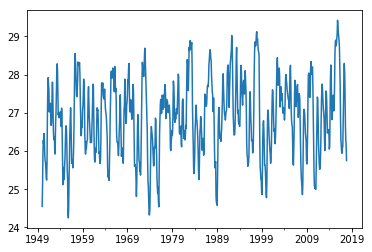

In [13]:
nino_esrl.plot()

In [14]:
nino_esrl.tail()

2017-08-01    26.69
2017-09-01    26.28
2017-10-01    26.14
2017-11-01    25.75
2017-12-01      NaN
Freq: MS, dtype: float64

#### `nino_esrl` is a [Pandas Series](http://pandas.pydata.org/pandas-docs/stable/dsintro.html#series), we casting it to a [Dataframe](http://pandas.pydata.org/pandas-docs/stable/dsintro.html#dataframe)

In [15]:
nino_esrl = nino_esrl.to_frame(name='NINO34')

#### calculating a climatology 

In [16]:
clim_esrl = nino_esrl.loc['1981':'2010',:]

In [17]:
clim_esrl = clim_esrl.groupby(clim_esrl.index.month).mean()

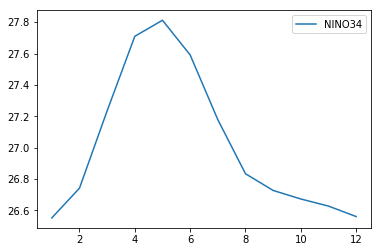

In [18]:
clim_esrl.plot()

#### calculating anomalies WRT a given climatology

In [19]:
def demean(x): 
    return x - x.loc['1981':'2010',:].mean()

In [20]:
nino_esrl = nino_esrl.groupby(nino_esrl.index.month).apply(demean)

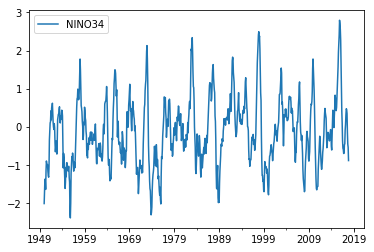

In [21]:
nino_esrl.plot()

### comparing with the NOAA Climate Prediction Center NINO3.4 index

In [22]:
nino_cpc = pd.read_table('http://www.cpc.ncep.noaa.gov/data/indices/ersst5.nino.mth.81-10.ascii', sep=r'\s+')

In [23]:
nino_cpc.tail()

,YR,MON,NINO1+2,ANOM,NINO3,ANOM.1,NINO4,ANOM.2,NINO3.4,ANOM.3
810,2017,7,21.65,-0.28,25.83,0.14,29.15,0.42,27.53,0.35
811,2017,8,20.68,-0.34,24.86,-0.24,28.86,0.22,26.69,-0.15
812,2017,9,19.92,-0.81,24.17,-0.76,28.72,0.06,26.28,-0.45
813,2017,10,20.21,-0.84,24.26,-0.70,28.56,-0.08,26.14,-0.53
814,2017,11,20.41,-1.29,24.02,-1.02,28.35,-0.21,25.75,-0.88


In [24]:
nino_cpc = nino_cpc.loc[:,['YR','MON','ANOM.3']]

In [25]:
nino_cpc.columns = ['year','month','nino34']

In [26]:
nino_cpc.loc[:,'day'] = 1

In [27]:
index = pd.to_datetime(nino_cpc.loc[:,['year','month','day']])

In [28]:
nino_cpc.index = index

In [29]:
nino_cpc.head()

,year,month,nino34,day
1950-01-01,1950,1,-2.00,1
1950-02-01,1950,2,-1.68,1
1950-03-01,1950,3,-1.37,1
1950-04-01,1950,4,-1.43,1
1950-05-01,1950,5,-1.63,1


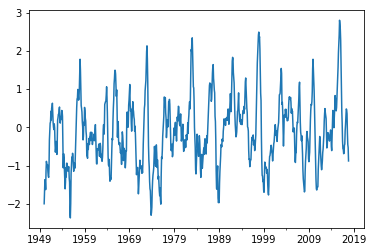

In [30]:
nino_cpc.nino34.plot()

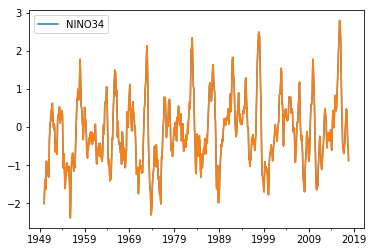

In [31]:
f, ax = plt.subplots()
nino_esrl.plot(ax=ax)
nino_cpc.nino34.plot(ax=ax)

In [32]:
nino_cpc_r3 = nino_cpc.rolling(window=3, min_periods=3).mean()

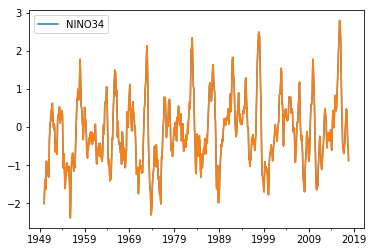

In [33]:
f, ax = plt.subplots()
nino_esrl.plot(ax=ax)
nino_cpc.nino34.plot(ax=ax)

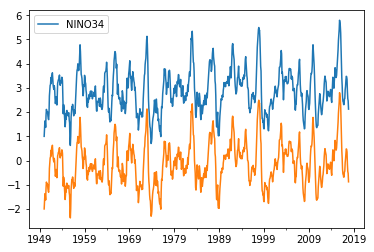

In [34]:
f, ax = plt.subplots()
(nino_esrl + 3).plot(ax=ax)
nino_cpc.nino34.plot(ax=ax)

## make your own indice from a climate field 

### download the ERSST V5 data using the [requests](http://docs.python-requests.org/en/master/) library

In [35]:
base_url = "https://www1.ncdc.noaa.gov/pub/data/cmb/ersst/v5/netcdf/"

In [36]:
opath = '../data/SST'

In [37]:
# for date in pd.date_range(start='1979-1-1', end='2017-10-1', freq='MS'):
#     filename = "ersst.v5.{:%Y%m}.nc".format(date)
#     r = requests.get(base_url + filename)
#     with open('{}/{}'.format(opath, filename),'wb') as f:
#         f.write(r.content)
#     dset = xr.open_dataset('{}/{}'.format(opath, filename))
#     dset = dset.sel(lat=slice(-40, 40), lon=slice(100,300))
#     os.remove('{}/{}'.format(opath, filename))
#     dset.to_netcdf('{}/{}'.format(opath, filename))
#     dset.close()

In [38]:
from glob import glob

In [39]:
lfiles = glob('../data/SST/*.nc')

In [40]:
lfiles.sort()

In [41]:
lfiles[:5]

['../data/SST/ersst.v5.197901.nc',
 '../data/SST/ersst.v5.197902.nc',
 '../data/SST/ersst.v5.197903.nc',
 '../data/SST/ersst.v5.197904.nc',
 '../data/SST/ersst.v5.197905.nc']

In [42]:
lfiles[-5:]

['../data/SST/ersst.v5.201706.nc',
 '../data/SST/ersst.v5.201707.nc',
 '../data/SST/ersst.v5.201708.nc',
 '../data/SST/ersst.v5.201709.nc',
 '../data/SST/ersst.v5.201710.nc']

In [43]:
dset = xr.open_mfdataset(lfiles)

In [44]:
dset

<xarray.Dataset>
Dimensions:  (lat: 41, lev: 1, lon: 101, time: 466)
Coordinates:
  * lat      (lat) float64 -40.0 -38.0 -36.0 -34.0 -32.0 -30.0 -28.0 -26.0 ...
  * lev      (lev) float64 0.0
  * lon      (lon) float64 100.0 102.0 104.0 106.0 108.0 110.0 112.0 114.0 ...
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 1979-03-01 ...
Data variables:
    sst      (time, lev, lat, lon) float64 dask.array<shape=(466, 1, 41, 101), chunksize=(1, 1, 41, 101)>
    ssta     (time, lev, lat, lon) float64 dask.array<shape=(466, 1, 41, 101), chunksize=(1, 1, 41, 101)>
Attributes:
    Conventions:                CF-1.6, ACDD-1.3
    metadata_link:              https://doi.org/10.7289/V5T72FNM
    id:                         ersst.v5.197901
    naming_authority:           gov.noaa.ncei
    title:                      NOAA ERSSTv5 (in situ only)
    summary:                    ERSST.v5 is developped based on v4 after revi...
    institution:                NOAA/NESDIS/NCEI/CCOG
    creator_na

In [45]:
dset = dset.squeeze(drop=True)

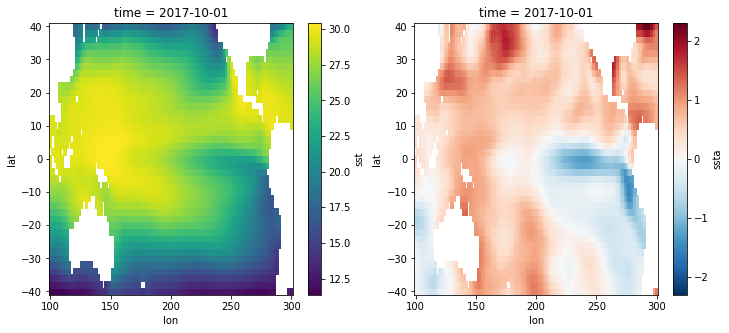

In [46]:
f, axes = plt.subplots(ncols=2, figsize=(12,5))
dset.sel(time='2017-10-01')['sst'].plot(ax=axes[0])
dset.sel(time='2017-10-01')['ssta'].plot(ax=axes[1])

### calculate a regional (box) average 

![](./images/oceanic-indices-map.gif)

+ Nino 1 : Latitude 0° to 5° S & Longitude 80° W to 90° W  
+ Nino 2 : Latitude 5° S to 10° S & Longitude 80° W to 90° W  
+ Nino 3 : Latitude 5°N to 5° S & Longitude 90° W to 150° W  
+ Nino 3.4 : Latitude 5° N to 5° S & Longitude 120° W to 170° W  
+ Nino 4 : Latitude 5°N to 5° S & Longitude 160° E to 150° W  

In [47]:
nino34 = {'latS': -5, 'latN': 5, 'lonW': 170, 'lonE': 120}

In [48]:
nino = dset.sel(lat=slice(nino34['latS'], nino34['latN']), lon=slice(360 - nino34['lonW'], 360 - nino34['lonE']))

In [49]:
nino_indice = nino.mean('lat').mean('lon')

In [50]:
nino_indice.load()

<xarray.Dataset>
Dimensions:  (time: 466)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 1979-03-01 ...
Data variables:
    sst      (time) float64 26.42 26.54 27.28 27.84 27.69 27.43 26.83 26.75 ...
    ssta     (time) float64 -0.1812 -0.2488 0.01697 0.146 -0.1237 -0.1282 ...

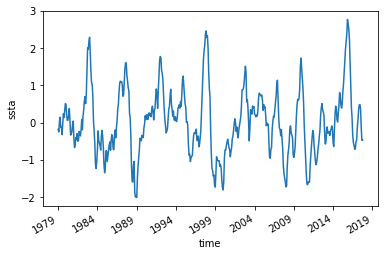

In [51]:
nino_indice['ssta'].plot()

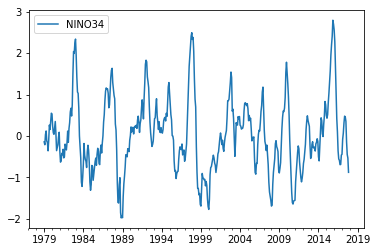

In [52]:
nino_esrl.loc['1979':,:].plot()

In [53]:
nino_indice_df = nino_indice.to_dataframe()

In [54]:
nino_indice_df.tail()

,sst,ssta
time,,
2017-06-01,28.045594,0.483936
2017-07-01,27.529682,0.379875
2017-08-01,26.689923,-0.123088
2017-09-01,26.279665,-0.475981
2017-10-01,26.223660,-0.471415


## Fantastic indices and where to find them 

### The Southern Oscillation Index (SOI)

can be found at the NCDC: 
    
[https://www.ncdc.noaa.gov/teleconnections/enso/indicators/soi/data.csv](https://www.ncdc.noaa.gov/teleconnections/enso/indicators/soi/data.csv)

In [55]:
url = 'https://www.ncdc.noaa.gov/teleconnections/enso/indicators/soi/data.csv'

In [56]:
SOI_ncdc = pd.read_table(url, sep=',', skiprows=1)

In [57]:
SOI_ncdc.loc[:,'Date'] = SOI_ncdc.loc[:,'Date'].apply(str) + '01'

In [58]:
SOI_ncdc.loc[:,'Date'] = pd.to_datetime(SOI_ncdc.loc[:,'Date'])

In [59]:
SOI_ncdc.index = SOI_ncdc.loc[:,'Date'] 

In [60]:
SOI_ncdc = SOI_ncdc.drop('Date', axis=1)

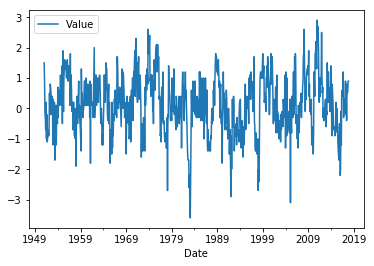

In [61]:
SOI_ncdc.plot()

#### calculate it yourself using the MSLP in Tahiti and Darwin, made available by the Australian BoM

In [62]:
def get_BOM_MSLP(station='tahiti'):
    
    import urllib.request, urllib.error, urllib.parse
    from dateutil import parser as dparser
    from datetime import datetime, timedelta
    import subprocess
    
    import pandas as pd
    
    url = "ftp://ftp.bom.gov.au/anon/home/ncc/www/sco/soi/{}mslp.html".format(station)
    
    req = urllib.request.Request(url)

    r = urllib.request.urlopen(req)

    data = r.read()

    data = data.splitlines()
    
    if station == 'tahiti':
        data = data[15:-1]
    else:
        data = data[14:-1]
    
    data = [x.decode('utf-8') for x in data]
    
    data = [x+'\n' for x in data]    
    
    with open('./{}_text'.format(station), 'w') as fout:
        fout.writelines(data)

    data = pd.read_table('./{}_text'.format(station),sep='\s+', engine='python', na_values='*', index_col=['Year'])
    
    subprocess.Popen(["rm {}*".format(station)], shell=True, stdout=True).communicate()
    
    return(data)

In [63]:
tahitidf = get_BOM_MSLP(station='tahiti')

In [64]:
tahitidf.tail()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2013,1010.0,1011.0,1013.1,1012.1,1013.5,1014.1,1014.7,1014.7,1014.6,1013.3,1012.0,1011.3
2014,1012.0,1010.3,1010.6,1012.3,1013.9,1013.5,1014.4,1014.4,1014.2,1013.2,1011.3,1009.9
2015,1009.3,1012.5,1010.8,1012.4,1013.0,1013.0,1013.7,1013.4,1013.3,1013.4,1011.6,1009.4
2016,1010.6,1009.1,1012.3,1010.5,1012.9,1014.1,1014.7,1014.9,1015.6,1012.6,1011.6,1010.7
2017,1010.7,1011.2,1012.3,1011.3,1013.4,1013.4,1015.4,1015.2,1015.8,1013.8,1012.1,NaN


In [65]:
darwindf = get_BOM_MSLP(station='darwin')

In [66]:
darwindf.tail()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2013,1005.8,1007.2,1007.2,1009.7,1010.8,1011.2,1012.5,1013.1,1011.6,1010.7,1007.7,1007.7
2014,1005.0,1006.0,1009.1,1008.9,1011.7,1012.5,1013.9,1014.5,1013.1,1011.6,1009.9,1007.5
2015,1006.5,1007.8,1008.9,1010.5,1013.1,1013.3,1015.0,1014.8,1013.9,1013.8,1009.5,1007.7
2016,1010.3,1008.7,1009.2,1010.8,1010.9,1012.2,1013.1,1012.4,1011.0,1010.4,1008.8,1006.7
2017,1006.0,1007.1,1007.4,1009.7,1011.7,1013.5,1013.2,1013.0,1012.3,1009.4,1007.4,NaN


### The Southern Annular Mode 

##### There are numerous versions of the SAM (Southern Annular Mode) index, a paper recently gave a comparison of the various definitions and implementations existing out there, see 

Ho, M., Kiem, A. S., and Verdon-Kidd, D. C.: The Southern Annular Mode: a comparison of indices, Hydrol. Earth Syst. Sci., 16, 967-982, https://doi.org/10.5194/hess-16-967-2012, 2012. available at the following URL: 
            
            
[https://www.hydrol-earth-syst-sci.net/16/967/2012/](https://www.hydrol-earth-syst-sci.net/16/967/2012/)

In a nutshell, the SAM can be derived either by calculating the difference between zonal mean MSLP (or geopotential) at 65S and 40S ([the Marshall SAM index](https://climatedataguide.ucar.edu/climate-data/marshall-southern-annular-mode-sam-index-station-based) is calculated that way) or by applying an EOF (PCA) decomposition of the pressure field south of 20S (usually in a reanalysis product, as EOF doesn't deal very well with missing values), this is the way the [CPC SAM index](http://www.cpc.ncep.noaa.gov/products/precip/CWlink/daily_ao_index/aao/aao.shtml) is calculated. 

here we'll see how to read the [SAM index calculated from the 20CRc reanalysis project](https://www.esrl.noaa.gov/psd/data/20thC_Rean/timeseries/monthly/SAM/)

In [67]:
url = 'https://www.esrl.noaa.gov/psd/data/20thC_Rean/timeseries/monthly/SAM/sam.20crv2c.long.data'

In [68]:
SAM_20CR = pd.read_table(url, skiprows=1, skipfooter=9, engine='python', sep=r'\s+', header=None)

In [69]:
SAM_20CR.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1851,-0.488,0.117,-0.315,-0.499,-0.473,-1.137,-2.096,-2.040,-0.190,0.628,0.334,0.341
1,1852,-1.133,-3.454,-2.110,-2.384,-1.467,-0.192,-2.143,-4.139,-1.072,-1.547,-0.778,-1.175
2,1853,-1.693,-3.406,-0.962,-2.549,-0.160,-0.656,-2.805,-1.065,-1.841,-2.974,-1.323,-1.354
3,1854,-1.684,-3.104,-1.714,-3.052,-1.372,-1.200,-2.399,-2.934,-2.857,-2.609,-0.401,-0.793
4,1855,-2.524,-2.811,-2.777,-0.630,-0.924,-1.718,-2.879,-3.717,-1.253,-0.670,-0.523,-1.453


In [70]:
SAM_20CR.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12
156,2007,-0.491,0.721,-0.943,-1.513,0.149,-0.444,-3.225,0.828,-0.205,-0.179,-0.270,2.408
157,2008,1.992,0.945,2.045,-1.709,-1.545,3.444,-0.618,0.268,2.008,2.533,2.071,1.018
158,2009,1.129,0.709,0.471,-0.669,-0.636,-0.422,-1.819,-2.467,0.360,0.844,-2.600,0.904
159,2010,-0.847,-1.906,1.164,1.352,2.133,4.136,3.924,2.532,2.091,2.315,2.254,0.921
160,2011,-0.564,2.026,-0.122,-0.165,2.705,0.139,-0.934,-1.616,-2.619,0.953,-1.061,2.421


In [71]:
SAM_20CR = SAM_20CR.iloc[:,1:].stack().to_frame()

In [72]:
SAM_20CR.columns = ['SAM']

In [73]:
len(SAM_20CR)

1932

In [74]:
SAM_20CR.tail()

SAM
160 8  -1.616
    9  -2.619
    10  0.953
    11 -1.061
    12  2.421

In [75]:
SAM_20CR.index = pd.date_range(start='1851-1-1',end='2011-12-31', freq='MS')

In [76]:
SAM_20CR.tail()

,SAM
2011-08-01,-1.616
2011-09-01,-2.619
2011-10-01,0.953
2011-11-01,-1.061
2011-12-01,2.421


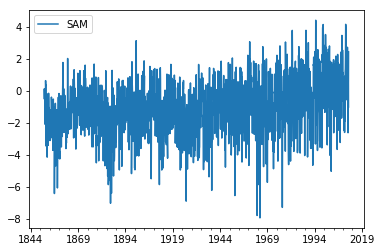

In [77]:
SAM_20CR.plot()

#### calculating the long-term linear trend using the stats submodule of [scipy](https://www.scipy.org/)

In [78]:
from scipy.stats import linregress

In [79]:
slope, intercept, r, p, stderr = linregress(np.arange(len(SAM_20CR)), SAM_20CR.loc[:,'SAM'].values)

In [80]:
slope

0.00090142306185654131

In [81]:
intercept

-1.9410693078373973

In [82]:
r

0.2977782036430382

In [83]:
p

7.3976850489763693e-41

In [84]:
trend = np.arange(len(SAM_20CR)) * slope + intercept

In [85]:
SAM_20CR.loc[:,'linear_trend'] = trend

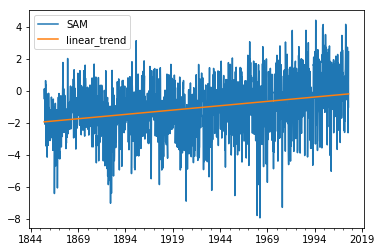

In [86]:
SAM_20CR.plot()

#### using the `detrend` function of [scipy.signal](https://docs.scipy.org/doc/scipy/reference/signal.html) to remove the trend

In [87]:
from scipy.signal import detrend

In [88]:
SAM_20CR.loc[:,'detrended'] = detrend(SAM_20CR.loc[:,'SAM'])

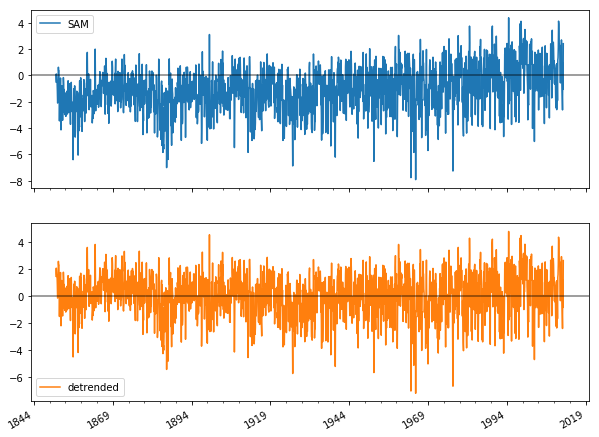

In [89]:
SAM_20CR.loc[:,['SAM','detrended']].plot(subplots=True, figsize=(10,8))
axes = plt.gcf().axes
axes[0].axhline(0, c='k', alpha=0.5)
axes[1].axhline(0, c='k', alpha=0.5)